In [140]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import metrics

red = "#E07182"
blue = "#4487D3"

In [10]:
def get_node_colors(sm, target):
    node_colors = []
    for node in sm.nodes():
        if node == target:
            node_colors.append(red)
        else:
            node_colors.append(blue)   
    return node_colors

## **Fenómeno a modelar**
    
**Rafa** y **Pipe** son dos colegas que viven en Valdivia, una ciudad del sur de Chile que suele tener mal clima. A pesar de esto, ellos gustan de salir después del trabajo a lanzar piedras y **romper ventanas** de casas abandonadas. Pipe suele salir más que Rafa a pesar del **mal clima**, pero de todas formas ambos tienden a salir menos si es que el clima no los favorece. Además de esto Pipe suele tener mejor puntería que Rafa

## **¿Como modelamos esto?**

### Variables:

- **Pipe**: será la variable binaria que dice si Pipe sale o no a romper ventanas
- **Rafa**: será la variable binaria que dice si Rafa sale o no a romper ventanas
- **MalClima**: será la variable binaria que nos dice si hay mal clima o no
- **RompeVentana**: será la variable binaria que nos dice si se rompen o no ventanas

### Distribuciones y relaciones:

\begin{align*}  
\textbf{MalClima} &\sim \text{Bernoulli}(0.8) \\  
\textbf{Pipe} &\sim \text{Bernoulli}(\textbf{MalClima}\cdot 0.70 + (1-\textbf{MalClima})\cdot 0.9) \\ 
\textbf{Rafa} &\sim \text{Bernoulli}(\textbf{MalClima}\cdot 0.40 + (1-\textbf{MalClima})\cdot 0.9) \\ 
\textbf{RompeVentana} &\sim \max\left\{\text{Bernoulli}(\textbf{Pipe}\cdot 0.90),  \text{Bernoulli}(\textbf{Rafa}\cdot 0.80)\right\}
\end{align*}

### Grafo causal del fenómeno

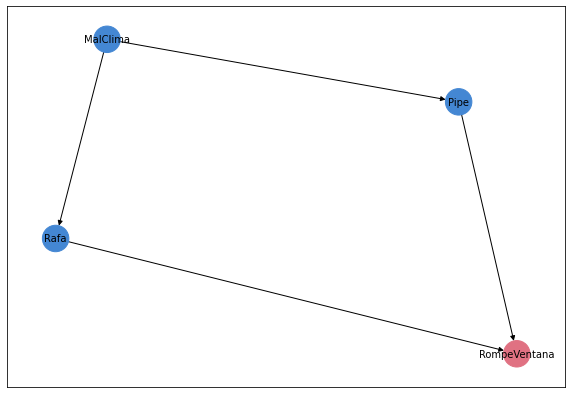

In [152]:
from causalnex.structure import StructureModel
import networkx as nx

target = "RompeVentana"

sm_teorico = StructureModel()
sm_teorico.add_edges_from([
    ('MalClima', 'Pipe'),
    ('MalClima', 'Rafa'),
    ('Pipe', 'RompeVentana'),
    ('Rafa', 'RompeVentana'),
])

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_teorico, 
    node_color=get_node_colors(sm_teorico, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

### Generar datos sintéticos

In [46]:
import pyro
import torch as th
import pyro.distributions as dist

In [153]:
n_samples = 1000

MalClima = pyro.sample('MalClima', dist.Bernoulli(0.8*th.ones(n_samples)))
Pipe = pyro.sample('Pipe', dist.Bernoulli(MalClima*0.7 + (1-MalClima)*0.9))
Rafa = pyro.sample('Pipe', dist.Bernoulli(MalClima*0.4 + (1-MalClima)*0.9))
PipeRompe = pyro.sample('PipeRompe', dist.Bernoulli(Pipe*0.9))
RafaRompe = pyro.sample('RafaRompe', dist.Bernoulli(Rafa*0.8))
RompeVentana = th.maximum(PipeRompe, RafaRompe)

In [154]:
data = pd.DataFrame({
    'MalClima': MalClima.numpy(),
    'Pipe': Pipe.numpy(),
    'Rafa': Rafa.numpy(),
    'RompeVentana': RompeVentana.numpy(),
}).astype(int)

data.head()

,MalClima,Pipe,Rafa,RompeVentana
0,1,0,1,1
1,1,1,0,1
2,0,1,1,1
3,0,0,1,1
4,1,1,0,1


In [156]:
#sanity check de tasa de salida de rafa cuando hay mal clima
data.groupby('MalClima')['Rafa'].mean()

MalClima
0    0.924242
1    0.422693
Name: Rafa, dtype: float64

### Estimación del grafo causal
se usa el algoritmo NOTEARS:

https://proceedings.neurips.cc/paper/2018/file/e347c51419ffb23ca3fd5050202f9c3d-Paper.pdf

In [157]:
from causalnex.structure import notears

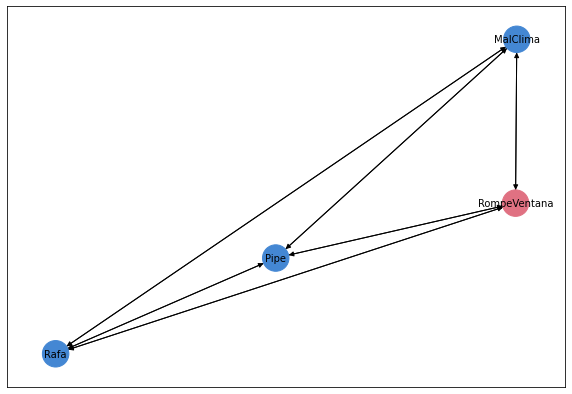

In [158]:
sm_notears = notears.from_pandas(data)

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

In [160]:
graph = pd.DataFrame({
    (u, v, w, abs(w)) for u, v, w in sm_notears.edges(data="weight")
}, columns=['node_0', 'node_1', 'weight', 'abs_weight'])

graph.sort_values(by='abs_weight')

,node_0,node_1,weight,abs_weight
1,MalClima,RompeVentana,0.000006,0.000006
9,RompeVentana,Pipe,0.000024,0.000024
3,Pipe,Rafa,0.000029,0.000029
7,RompeVentana,Rafa,0.000072,0.000072
10,MalClima,Pipe,0.000078,0.000078
11,MalClima,Rafa,0.000195,0.000195
8,Rafa,MalClima,-0.113368,0.113368
0,Pipe,MalClima,0.200690,0.200690
2,Rafa,RompeVentana,0.350926,0.350926
6,RompeVentana,MalClima,0.653327,0.653327


está raro el grafo estimado! que la ventana se rompa o no, no debería influir en si pipe sale a tirar piedras

#### Restricciones

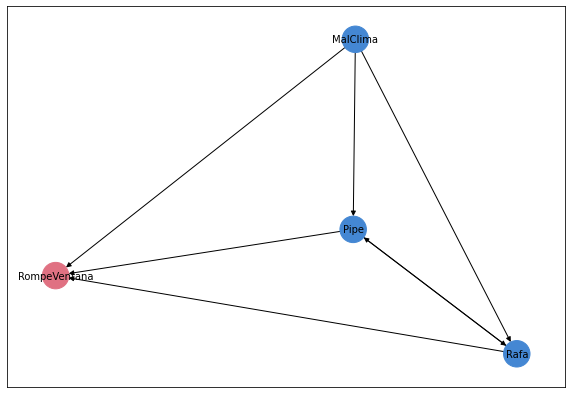

In [165]:
tabu_edges = [
    ('RompeVentana', 'Pipe'),
    ('RompeVentana', 'Rafa'), 
    ('Pipe', 'MalClima'),
    ('Rafa', 'MalClima'),
    ('RompeVentana', 'MalClima')
]

sm_notears = notears.from_pandas(data, tabu_edges=tabu_edges)

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

In [166]:
graph = pd.DataFrame({
    (u, v, w, abs(w)) for u, v, w in sm_notears.edges(data="weight")
}, columns=['node_0', 'node_1', 'weight', 'abs_weight'])

graph.sort_values(by='abs_weight')

,node_0,node_1,weight,abs_weight
5,Rafa,Pipe,0.000202,0.000202
2,MalClima,Rafa,0.089519,0.089519
0,MalClima,RompeVentana,0.161995,0.161995
1,Rafa,RompeVentana,0.334462,0.334462
3,Pipe,Rafa,0.484894,0.484894
4,Pipe,RompeVentana,0.638945,0.638945
6,MalClima,Pipe,0.688242,0.688242


In [167]:
sm_notears.remove_edges_below_threshold(0.000202)

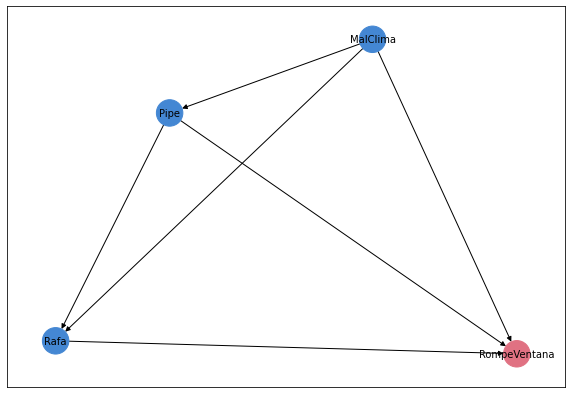

In [168]:
fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

### Entrenar modelo usando grafo teorico

In [169]:
from causalnex.network import BayesianNetwork

model = BayesianNetwork(sm_teorico)

/opt/conda/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


In [170]:
train = data.iloc[:900]
test = data.iloc[900:]

In [171]:
#extrae posibles valores (estados)que pueden tomar variables
model = model.fit_node_states(train) 

#fitear modelo
model = model.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [172]:
predictions = model.predict_probability(test, target)
predictions.head()

,RompeVentana_0,RompeVentana_1
900,0.024000,0.976000
901,0.024000,0.976000
902,0.091216,0.908784
903,0.992647,0.007353
904,0.024000,0.976000


In [173]:
def compute_pr_auc(target_values, prob_values):
    precision, recall, _ = metrics.precision_recall_curve(
        target_values, 
        prob_values,
    )
    return round(100*metrics.auc(recall, precision), 2)

In [174]:
compute_pr_auc(test['RompeVentana'], predictions['RompeVentana_1'])

95.14

In [175]:
from causalnex.evaluation import roc_auc

roc_auc(model, test, target)[-1]

0.9518

### Preguntas contrafactuales

In [176]:
from causalnex.inference import InferenceEngine

In [187]:
ie = InferenceEngine(model)

#### ¿Que pasaria si siempre hay buen clima?

*Notamos que la estimación de **Pipe** y **Rafa** es muy precisa (ambas cerca de **0.9**)*

In [182]:
ie.do_intervention("MalClima", 0)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 1.0, 1: 0.0},
 'Pipe': {0: 0.10810810810810811, 1: 0.8918918918918919},
 'Rafa': {0: 0.07567567567567568, 1: 0.9243243243243243},
 'RompeVentana': {0: 0.057808149109036686, 1: 0.9421918508909632}}

#### ¿Que pasaria si siempre hay buen clima?

*Notamos que la estimación de **Pipe** y **Rafa** es muy precisa (ambas cerca de **Pipe~0.7** y **Rafa ~ 0.4**)*

In [183]:
#que pasaria si siempre hay mal clima
ie.do_intervention("MalClima", 1)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 0.0, 1: 1.0},
 'Pipe': {0: 0.29902642559109877, 1: 0.7009735744089014},
 'Rafa': {0: 0.5785813630041725, 1: 0.4214186369958276},
 'RompeVentana': {0: 0.24576747123657927, 1: 0.7542325287634208}}

In [ ]:
marginals = ie.query({})
marginals